---
[![Linkedin](https://content.linkedin.com/content/dam/brand/site/img/logo/logo-r.png) Join group for discussion on Machine Learning](https://www.linkedin.com/groups/13570295) 

---

# License
Copyright © 2018, Rohit Sharma. Paripath Inc.

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or(at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the [GNU General Public License](www.gnu.org/licenses/gpl-3.0.html) for more details.

>[License](#scrollTo=Y3n1rKivjiw0)

>[10 Class Classification of Cells Using Neural Network](#scrollTo=-cI7TvCTiDS9)

>>[Dataset](#scrollTo=7zTtLHoJiDTI)

>[Load cells](#scrollTo=jpCXhhdxiDTL)

>[Randomize Dataset](#scrollTo=2RuDlHBuiDTW)

>[Reformat Dataset](#scrollTo=Zya2SABiiDTb)

>[Normalize Dataset](#scrollTo=nPbbsIzviDTg)

>[Divide dataset](#scrollTo=2TEdkp4xiDTv)

>>[Declare Graph Variables](#scrollTo=XNug9X4TiDT5)

>>[Compute Graph](#scrollTo=Tz2s2QP9iDT-)

>>[Parameters and Function](#scrollTo=Qs5W2bZJiDUJ)

>>[Training the Model](#scrollTo=cBgE5fQNiDUP)

>[Cost and Accuracy](#scrollTo=FGFZl0M2iDUX)

>[Confusion Matrix](#scrollTo=9I_oaPnhiDUe)

>[Conclusion](#scrollTo=VvmAUHfpiDUk)



# 10 Class Classification of Cells Using Neural Network

In [1]:
import sys
import os
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

import urllib.request; # for reading the data
from bs4 import BeautifulSoup
import requests

print('Python version     :', '{0[0]}.{0[1]}'.format(sys.version_info))
print('Tensorflow version :', tf.__version__)
print('numpy version      :', np.__version__)
np.random.seed(0)
tf.random.set_seed(2)

Python version     : 3.9
Tensorflow version : 2.9.1
numpy version      : 1.20.3


## Dataset

Our dataset consists of total of over 4,200 cells with a total of 10 categories;  
Each cell in the dataset is represented as a 2D matrix of transistor devices and their parameters given below:


| Device | param1 | param2 | param3 | param4 | param5 | ...... | ...... | param13 |
|--------|--------|--------|--------|--------|--------|--------|--------|---------|
|   10   |    6   |    6   |    3   |    3   |    5   |        |        |    2    |
|   10   |    8   |    3   |    2   |    4   |    4   |    2   |    3   |    6    |
|   20   |    7   |    3   |    2   |    4   |    4   |    2   |    3   |    2    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...   |  ...    |
|   20   |    7   |    3   |    2   |    4   |    5   |    2   |    3   |    2    |


Entire dataset consists of 4,200 such tables is shown in the next picture.


![Cell Dataset As Stack Of Tables](https://github.com/srohit0/mida/blob/master/data/CellDatasetAsStackOfTables.jpg?raw=true =580x560)

# Load cells

1. Set parameters of the cells (like max devices and feature per device etc).
2. Read cells off the the internet

In [2]:
# max_devices_per_cell is also max number of rows in circuit files in the training set
max_devices_per_cell = 369; 
# feature_per_device is different from max number of cols (14) in circuit files in training set
feature_per_device   = 5; 
feature_indices = (0,2,5,8,11)

def load_one_cell(cell_file):
    cell_cols = 14
    cell_data = np.zeros(shape=(max_devices_per_cell, cell_cols), dtype=np.float32)
    #print(cell_file)
    decoded_cell  = urllib.request.urlopen(cell_file)
    cell_mat  = decoded_cell.read().decode('utf-8')
    cell_mat  = np.fromstring(cell_mat, dtype=int, sep=' ').reshape(-1, cell_cols)
    nrows     = cell_mat.shape[0]
    ncols     = cell_mat.shape[1]
    cell_data[:nrows, :ncols] = cell_mat
    cell_data = cell_data[:, feature_indices]
    return cell_data

#load_one_cell('https://raw.githubusercontent.com/srohit0/mida/master/data/cells/FDN/FDNQ_1.mat')

In [3]:
# return list of files with ext in a dir over http
def httpDir(url, ext=''):
#     from urllib.parse import urlparse
#     parsed_uri = urlparse(url)
#     base_url   = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    base_url = 'https://raw.githubusercontent.com'

    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [base_url + node.get('href').replace('blob/', '') for node in soup.find_all('a') if node.get('href').endswith(ext)]
 
def load_cells(folder):
  #Load the data for a single label.
  cell_files = httpDir(folder, 'mat')
  #print(cell_files)
  dataset = np.zeros(shape=(len(cell_files), max_devices_per_cell, feature_per_device),
                         dtype=np.float32)
  cell_index = 0
  for cell_file in cell_files:
    cell = os.path.basename(cell_file)
    try:
      cell_data = load_one_cell(cell_file)
      #print (cell, 'cell data', type(cell_data))

      cell_rows = cell_data.shape[0]
      cell_cols = cell_data.shape[1]
      dataset[cell_index, :cell_rows, :cell_cols] = cell_data

      cell_index = cell_index + 1
    except IOError as e:
      print('Could not read:', cell_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:cell_index, :, :]

  print(os.path.basename(folder), ': shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
  return dataset

label_list = ['FDN', 'LD', 'ADDH', 'MAJ', 'AOA', 'ADDF', 'CKG', 'FDP', 'INV', 'EN']
n_labels   = len(label_list); # num_classes
for label_index in range(n_labels):
    cell_dataset = load_cells('https://github.com/srohit0/mida/raw/master/data/cells/' + label_list[label_index])
    #print (type(cell_dataset))
    cell_labels = np.zeros((cell_dataset.shape[0], n_labels))
    cell_labels[:, label_index] = 1
    if label_index:
        dataset = np.append(dataset, cell_dataset, axis=0)
        labels  = np.append(labels,  cell_labels,  axis=0)
    else:
        dataset = cell_dataset
        labels  = cell_labels

print('dataset: shape=', dataset.shape, ', Mean=', np.mean(dataset), ', sigma=', np.std(dataset))
print('labels : shape=', labels.shape)

FDN : shape= (192, 369, 5) , Mean= 0.8676688 , sigma= 3.38401
LD : shape= (192, 369, 5) , Mean= 0.44800135 , sigma= 2.2717547
ADDH : shape= (208, 369, 5) , Mean= 0.5702705 , sigma= 2.5181172
MAJ : shape= (320, 369, 5) , Mean= 0.7173425 , sigma= 2.7298725
AOA : shape= (384, 369, 5) , Mean= 0.6993281 , sigma= 2.9019353
ADDF : shape= (464, 369, 5) , Mean= 1.7197739 , sigma= 4.9835944
CKG : shape= (560, 369, 5) , Mean= 1.4762921 , sigma= 4.818165
FDP : shape= (608, 369, 5) , Mean= 0.77752906 , sigma= 3.1884894
INV : shape= (614, 369, 5) , Mean= 0.34826055 , sigma= 2.0792024
EN : shape= (736, 369, 5) , Mean= 0.8509058 , sigma= 3.0373306
dataset: shape= (4278, 369, 5) , Mean= 0.8898671 , sigma= 3.4547768
labels : shape= (4278, 10)


# Randomize Dataset

In [15]:
# randomize dataset and labels together to keep'em in sync.
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:]
#   shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# randomize dataset
dataset, labels = randomize(dataset, labels)

print('Full dataset: no. of cells=', dataset.shape, 'Min=', np.min(dataset), 'Max=',np.max(dataset), 
      'Mean=', np.mean(dataset), 'Sigma=', np.std(dataset))

Full dataset: no. of cells= (4278, 1845) Min= 0.0 Max= 1.0 Mean= 0.017797336 Sigma= 0.06909552


# Reformat Dataset

In [16]:
def reformat(dataset):
    dataset = dataset.reshape((-1, max_devices_per_cell*feature_per_device))
    return dataset

dataset = reformat(dataset)
print(dataset.shape)

(4278, 1845)


# Normalize Dataset

In [17]:
# normalize the dataset between 0 and 1.
data_mean = 0;
data_std  = (np.max(dataset)-np.min(dataset));

def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)

print('Min=', np.min(dataset), 'Max=',np.max(dataset), 'Mean=',np.mean(dataset), 'sigma=', np.std(dataset))
print('Dataset size', dataset.shape)
#print('dataset feature min vector = ', np.min(dataset, axis=0))
#print('dataset feature max vector = ', np.max(dataset, axis=0))

Min= 0.0 Max= 1.0 Mean= 0.017797336 sigma= 0.06909552
Dataset size (4278, 1845)


# Divide dataset
into training dataset and validation dataset

In [18]:
# training dataset percentage is 80%
def divide_dataset(dataset, labels):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index, :]
    t_Y = labels[:train_index,:]
    v_X = dataset[train_index:,:]
    v_Y = labels[train_index:,:]
    
    return t_X, t_Y, v_X, v_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset, labels)

print(train_X.shape)

(3422, 1845)


## Declare Graph Variables

Place to declare place holders and variables for compute graph

In [19]:
SIGMA      = np.sqrt(2.0/train_X.shape[0])

# Parameters
learning_rate = 1e-2
l2_loss_beta  = 1e-5
training_epochs = 1000
display_step = 50

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 32   # 2nd layer number of neurons
n_features = train_X.shape[1]; # num_inputs
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
# tf Graph input
t_dataset = tf.placeholder(tf.float32, shape=(None, n_features), name='t_dataset');
t_labels  = tf.placeholder(tf.float32, shape=(None, n_labels), name='t_labels');


weights = {
    'h1': tf.Variable(tf.truncated_normal(shape=[n_features, n_hidden_1], mean=3.0*SIGMA, 
                                          stddev=SIGMA, dtype=tf.float32), trainable=True),
    'h2': tf.Variable(tf.truncated_normal(shape=[n_hidden_1, n_hidden_2], mean=3.0*SIGMA, 
                                           stddev=SIGMA, dtype=tf.float32), trainable=True),
    'out': tf.Variable(tf.truncated_normal(shape=[n_hidden_2, n_labels], mean=3.0*SIGMA, 
                                           stddev=SIGMA, dtype=tf.float32), trainable=True)
}
biases = {
    'b1': tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_hidden_1]), trainable=True),
    'b2': tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_hidden_2]), trainable=True),
    'out': tf.Variable(tf.constant(value=SIGMA, dtype=tf.float32, shape=[n_labels]), trainable=True)
}

## Compute Graph
Construct a Neural Network model

In [20]:
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1a = tf.nn.relu6(layer_1); #activation
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1a, weights['h2']), biases['b2'])
    layer_2a = tf.nn.relu6(layer_2) #activation
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2a, weights['out']) + biases['out']
    return out_layer

## Parameters and Function
Neural network parameters and functionss

In [21]:
# Construct model
predictions = neural_net(t_dataset)

t_labels_cls       = tf.argmax(t_labels, axis=1)
predictions_cls    = tf.argmax(predictions, axis=1)
correct_prediction = tf.equal(predictions_cls, t_labels_cls)
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=predictions,
                                                               labels=t_labels_cls)

# L2 loss
regularizers = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['out'])

# Cost
cost = tf.reduce_mean(cross_entropy + l2_loss_beta * regularizers)

# Optimization algorithm
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training the Model

In [23]:
# Start training
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

t_start = datetime.now()

for epoch in range(training_epochs):

    sess.run(optimizer, feed_dict={t_dataset:train_X, t_labels:train_Y})
#     sess.run(optimizer, feed_dict={train_X, train_Y})

    #Display logs per epoch step
    if (epoch+1) % display_step == 0:

        t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
        v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:valid_X, t_labels:valid_Y})
        print ("[", "{:4d}".format((datetime.now()-t_start).seconds), 
               "sec ] Epoch:", '%04d' % (epoch+1), 
               "cost=", "{:.5f}".format(t_cost),
               "train acc=", "{:.5f}".format(t_acc),
               "valid acc=", "{:.3f}".format(v_acc))

print( "\nOptimization Finished!" )

[   10 sec ] Epoch: 0050 cost= 1.14433 train acc= 0.53156 valid acc= 0.513
[   20 sec ] Epoch: 0100 cost= 0.64098 train acc= 0.76797 valid acc= 0.718
[   30 sec ] Epoch: 0150 cost= 0.29362 train acc= 0.92811 valid acc= 0.879
[   41 sec ] Epoch: 0200 cost= 0.14818 train acc= 0.97633 valid acc= 0.932
[   51 sec ] Epoch: 0250 cost= 0.07970 train acc= 0.99211 valid acc= 0.950
[   62 sec ] Epoch: 0300 cost= 0.17388 train acc= 0.95120 valid acc= 0.904
[   72 sec ] Epoch: 0350 cost= 0.05355 train acc= 0.99942 valid acc= 0.965
[   81 sec ] Epoch: 0400 cost= 0.04418 train acc= 0.99942 valid acc= 0.964
[   92 sec ] Epoch: 0450 cost= 0.03898 train acc= 0.99942 valid acc= 0.965
[  102 sec ] Epoch: 0500 cost= 0.03553 train acc= 0.99942 valid acc= 0.965
[  111 sec ] Epoch: 0550 cost= 0.03290 train acc= 0.99942 valid acc= 0.965
[  121 sec ] Epoch: 0600 cost= 0.03079 train acc= 0.99942 valid acc= 0.965
[  131 sec ] Epoch: 0650 cost= 0.02905 train acc= 0.99942 valid acc= 0.965
[  141 sec ] Epoch: 0700 

# Cost and Accuracy

In [24]:
# Find cost on training dataset.
t_cost, t_acc = sess.run([cost, accuracy], feed_dict={t_dataset:train_X, t_labels:train_Y})
v_cost, v_acc = sess.run([cost, accuracy], feed_dict={t_dataset:valid_X, t_labels:valid_Y})

print ("Training   cost    =", t_cost)
print ("Validation cost    =", v_cost, '\n')
print("Training   Accuracy =", t_acc)
print("Validation Accuracy =", v_acc)

Training   cost    = 0.020964697
Validation cost    = 0.11957481 

Training   Accuracy = 0.9994155
Validation Accuracy = 0.9661215


# Confusion Matrix

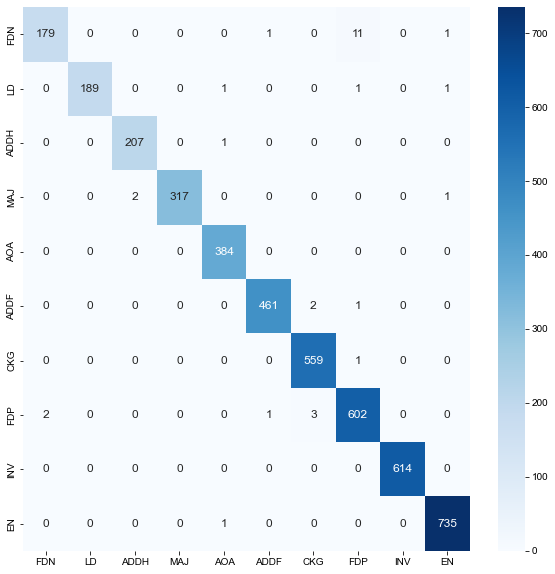

In [25]:
pred = sess.run(predictions, feed_dict={t_dataset:dataset, t_labels:labels})
cm = tf.confusion_matrix(labels=np.argmax(labels, axis=1), predictions=np.argmax(pred, axis=1), num_classes=n_labels)
cm_ary = cm.eval(session=sess)

plt.figure(figsize = (n_labels,n_labels))
sn.heatmap(cm_ary,   xticklabels=label_list, yticklabels=label_list,
           cmap="Blues", annot=True, fmt='d', annot_kws={"size": 12})# font size
sn.set(font_scale=1.0)#for label size
plt.show()

# Conclusion
Neural networks gave us reasonable accuracy of over 90% in both training and validation sets.

In the confusion matrix, it is easy to see that EN (ExNor function) and MAJ (majority function) have large numbers of false predicions. 

We also know that these two categories of cells have similar structural implementation. It is speculated that neural network **`magically`** figures this out. 

In [26]:
#sess.close()

# Credit:

[Machine Intelligence in Design Automation](amzn.to/2paZ53b)

---

[![Machine Intelligence in Design Automation](https://qph.ec.quoracdn.net/main-qimg-be4b2dd87b0ef610f4fda06b89904bd5)](http://amzn.to/2paZ53b)